In [197]:
import tenpy
from tenpy.networks.mps import MPS
from tenpy.algorithms import dmrg, tebd, vumps
import yaml
from chiral_magnet import *
from aux.plot_lobs import *
import numpy as np
import pandas as pd
import h5py

import logging.config

# create the config file for logs
conf = {
    'version': 1,
    'disable_existing_loggers': False,
    'formatters': {'custom': {'format': '%(levelname)-8s: %(message)s'}},
    'handlers': {'to_stdout': {'class': 'logging.StreamHandler',
                 'formatter': 'custom',
                 'level': 'INFO',
                 'stream': 'ext://sys.stdout'}},
    'root': {'handlers': ['to_stdout'], 'level': 'DEBUG'},
}
# start logging
logging.config.dictConfig(conf)

In [198]:
pwd = '/Users/andreas/gits/skyrmion_liquid/'
with open(f'{pwd}cm_triangular.yml', 'r') as f:
    sim = yaml.safe_load(f)
sim['model_params']['Bz'] = -0.2
# sim['model_params']['Bz'] = -0.822
M = chiral_magnet(sim['model_params'])
dmrg_params = sim['algorithm_params']

INFO    : chiral_magnet: reading 'lattice'='my_triangular'
INFO    : chiral_magnet: reading 'bc_MPS'='infinite'
INFO    : chiral_magnet: reading 'bc_x'='periodic'
INFO    : chiral_magnet: reading 'Lx'=7
INFO    : chiral_magnet: reading 'Ly'=5
INFO    : chiral_magnet: reading 'bc_y'='periodic'
INFO    : chiral_magnet: reading 'J'=[-1.0, -1.0, -1.0]
INFO    : chiral_magnet: reading 'Bz'=-0.2
INFO    : chiral_magnet: reading 'D'=[0.0, 0.0, 1.0]
INFO    : chiral_magnet: reading 'bc_classical'=True


In [199]:
sites = M.lat.mps_sites()
psi = MPS.from_desired_bond_dimension(sites, 1, bc=sim['model_params']['bc_MPS'])

INFO    : Generated MPS of bond dimension [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] from random matrices.


In [200]:
dmrg_params['trunc_params']['chi_max'] = 32
dmrg_params['max_sweeps'] = 100
dmrg_params['max_E_err'] = 1e-6
dmrg_params['max_S_err'] = 1e-5
dmrg_params['active_sites'] = 1

# mpo = M.calc_H_MPO()
# mpo.apply(psi, {'compression_method':'SVD', 'trunc_params':{'chi_max':dmrg_params['trunc_params']['chi_max']}})
# mpo.apply(psi, {'compression_method':'SVD', 'trunc_params':{'chi_max':dmrg_params['trunc_params']['chi_max']}})
# mpo.apply(psi, {'compression_method':'SVD', 'trunc_params':{'chi_max':dmrg_params['trunc_params']['chi_max']}})
# psi.canonical_form()
# eng = dmrg.SingleSiteDMRGEngine(psi, M, dmrg_params)
info = dmrg.run(psi, M, dmrg_params)
# E, psi = eng.run()

INFO    : DMRG: reading 'active_sites'=1
INFO    : DMRG: reading 'diag_method'='lanczos'
INFO    : DMRG: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO    : DMRG: subconfig 'lanczos_params'=Config(<4 options>, 'lanczos_params')
INFO    : start environment_sweep
INFO    : trunc_params: reading 'chi_max'=32
INFO    : trunc_params: reading 'svd_min'=1e-12
INFO    : DMRG: reading 'N_sweeps_check'=1
INFO    : DMRG: subconfig 'mixer_params'=Config(<3 options>, 'mixer_params')
INFO    : DMRG: reading 'mixer'='SubspaceExpansion'
INFO    : activate SubspaceExpansion with initial amplitude 1e-12
INFO    : DMRG: reading 'max_sweeps'=100
INFO    : Running sweep with optimization
INFO    : lanczos_params: reading 'N_min'=2
INFO    : lanczos_params: reading 'N_max'=3
INFO    : lanczos_params: reading 'reortho'=False
INFO    : lanczos_params: reading 'N_cache'=3
INFO    : Disable mixer after 1 sweeps, final amplitude 6.666666666666667e-13.
INFO    : deactivate SubspaceExpansion wit

KeyboardInterrupt: 

In [ ]:
# -0.7127754326086594, max S=0.7725663141062246

# import h5py
# from tenpy.tools import hdf5_io

# with h5py.File(f"B11_7sites.h5", 'r') as f:
#     psi = hdf5_io.load_from_hdf5(f, 'psi')


In [ ]:
import h5py
from tenpy.tools import hdf5_io

data = {"psi": psi, "parameters": sim}

with h5py.File(f"save.h5", 'w') as f:
    hdf5_io.save_to_hdf5(f, data)

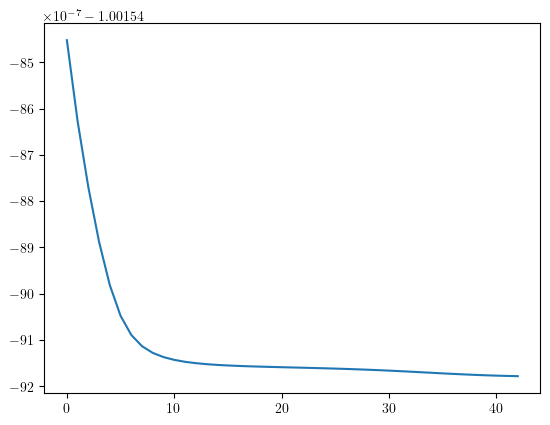

In [ ]:
plt.plot(info['sweep_statistics']['E'][10:])

/var/folders/ln/c8hsr9h52cv12mv3lyfbnm540000gn/T/ipykernel_13918/2696234917.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


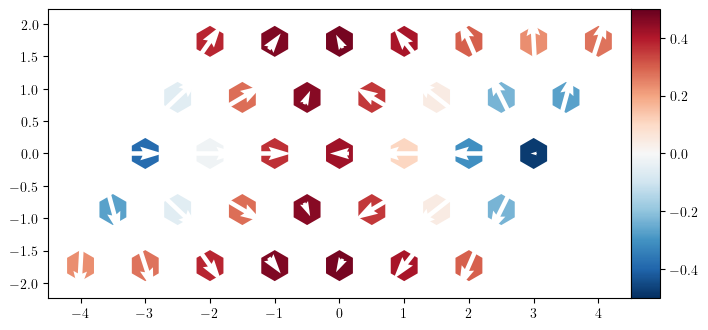

In [ ]:
import copy
psic = copy.deepcopy(psi)

# i = 4
# pos = 2 + 5*(i-1)
# psic.apply_local_op(pos,"Sp",unitary=True,understood_infinite=True)
# psic.apply_local_op(pos,"Sm",unitary=True,understood_infinite=True)
# psic.canonical_form_infinite1()

Sx,Sy,Sz = [psic.expectation_value(f'S{i}') for i in 'xyz']

lat = M.lat
pos = np.asarray([lat.position(lat.mps2lat_idx(i)) for i in range(psi.L)])
pos_av = np.mean(pos, axis=0)
pos = pos - pos_av

df = pd.DataFrame()
df['x'] = pos[:,0]
df['y'] = pos[:,1]
df['S_x'] = Sx
df['S_y'] = Sy
df['S_z'] = Sz
df['S'] = (Sx**2+Sy**2+Sz**2)**0.5

fig, ax = plt.subplots(1,1)

imag = ax.scatter(df['x'], df['y'], marker='h', edgecolor='None', s=500, cmap='RdBu_r', c=df['S_z'], vmin=-0.5, vmax=0.5)
ax.quiver(df['x'], df['y'], df['S_x'], df['S_y'], units='xy', width=0.07, scale=0.5, pivot='middle', color='white')
ax.set_aspect('equal')
# ax.set_title(title)

axins = inset_axes(
    ax,
    width="5%",  # width: 5% of parent_bbox width
    height="100%",  # height: 50%
    loc="lower left",
    bbox_to_anchor=(1, 0, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0
)
cbar = fig.colorbar(imag, cax=axins, orientation = 'vertical')
# ax.axis('off')

ax.set_xlim([min(df['x'])-0.5, max(df['x'])+0.5])
ax.set_ylim([min(df['y'])-0.5, max(df['y'])+0.5])

plt.tight_layout()
plt.show()

In [ ]:
psi.correlation_length()

42.05651870338662

In [ ]:
'Bz', 8, 16, 32, 64
1.10, 7.104715923647071, 18.729321953822396, 40.546592006127476, 93.12263706470813
1.09, 5.732758355717317,
1.08, 5.81521919303581,
1.07, 5.846643768967938,
1.06, 8.239652815496937,
1.05, 8.282054362587377,
1.04, 8.32412370278847,
1.03, 9.910531234326305, 22.19791960805098, 51.245699148686455
1.02, 10.011916941333121, 22.238881709382838, 51.42607677674843
1.01, 8.444475702846196, 22.262383865099387, 51.6895412187837
1.00, 10.249322785835995, 22.336608670123677, 51.862868951291766

(1.0, 10.249322785835995, 22.336608670123677, 51.862868951291766)

In [ ]:
16.786754927621395/5.694804577720066
38.370857178069976/16.786754927621395
# 20.928301551720914/8.464997714560772
53.02201451490466/20.928301551720914

2.533507766211669